In [1]:
import sys
import os

sys.path.append(os.getenv("CODE_PATH"))
sys.path.append(os.getenv("FIN_DATABASE_PATH"))

import plotly.graph_objects as go
import pandas as pd
import numpy as np
from sqlalchemy.orm import sessionmaker
from sqlalchemy import create_engine, select
from datetime import datetime, timedelta
import logging
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import ta
from log_config import setup_logging
from Data.connect import engine, DailyStockData, HourlyStockData, OneMinuteStockData, FiveMinuteStockData,FifteenMinuteStockData, StockSplits, StockNews, CompanyFinancials
from Pre_Processing.pre_processing import PreProcessing
from Feature_Engineering.feature_engineering import TechnicalIndicators
from pipeline import Pipeline
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import root_mean_squared_error as rmse
from arch import arch_model

In [2]:
#Defining the tickers
tickers = ['AAPL', 'MSFT', 'SPY']

In [3]:
#Using the pipeline script to retrieve data for the above tickers from the SQL database.

pipe = Pipeline(tickers)
minute_data = pipe.pipeline(timespan='minute',start_date='2018-01-01',end_date='2019-01-01')
hourly_data = pipe.pipeline(timespan='hour',start_date='2018-01-01',end_date='2019-01-01')
daily_data = pipe.pipeline(timespan='daily',start_date='2018-01-01',end_date='2019-01-01')


#### Applying the Approach from Young Li's Paper: 
**"A Practical Model for Prediction of Intraday Volatility"**
And testing with GARCH models instead of EWMA



#### Below we will create the Intraday Vol class.This class will contain multiple functions that will be used to predict the intraday volatility of the stock data according to the model described in Young Li's paper

In [21]:
class IntradayVol:
    def __init__(self,tickers, hf_data, lf_data, daily_data, timespan,  decay_factor = 0.94):
        """args:
        hf_data: higher frequency dataframe
        lf_data: lower frequency dataframe
        daily_data: daily dataframe
        timespan: timespan of the lower frequency data to aggregate : '15M', '1H', '1D', '1W....'"""
        self.tickers = tickers
        self.hf_data = hf_data
        self.lf_data = lf_data
        self.daily_data = daily_data
        self.timespan = timespan
        self.decay_factor = decay_factor
        self._ewma_vol_cache = {}

    
    def ewma_vol(self):
        """Calculate daily vol using EWMA model with caching and modify the DataFrame in place."""
        if self._ewma_vol_cache: 
            return self._ewma_vol_cache
        
        vol_results = {}
        for ticker in self.tickers:
            df = self.daily_data [ticker] 

            # Calculate squared log returns
            df['squared_log_ret'] = df['return'] ** 2 ##CHANGE THIS BACK
            df['squared_log_ret'].bfill(inplace=True)

            # Initialize the new column directly
            df['daily_vol_squared'] = np.nan
            df.loc[df.index[0], 'daily_vol_squared'] = df['squared_log_ret'].iloc[0]

            # Calculate the EWMA of the squared log returns
            for i in range(1, len(df)):
                df.loc[df.index[i], 'daily_vol_squared'] = (
                    self.decay_factor * df['daily_vol_squared'].iloc[i-1] +
                    (1 - self.decay_factor) * df['squared_log_ret'].iloc[i]
                )

            # Calculate the ewma_vol and add it directly to the DataFrame
            df['ewma_vol'] = np.sqrt(df['daily_vol_squared'])

            # Store the result in the cache
            vol_results[ticker] = df['ewma_vol']
        
        self._ewma_vol_cache = vol_results  # Cache the result
        return vol_results

    
    
    def garch_vol(self, model_type='GARCH'):
        """Calculate daily vol using GARCH(1,1) model and modify the DataFrame in place."""
        vol_results = {}
        for ticker in self.tickers:
            df = self.daily_data[ticker]  
            df.dropna(subset=['log_ret'], inplace=True)  

            # Fitting GARCH model
            model = arch_model(df['return'] * 100, vol=model_type, p=1, q=1) #CHANGE THIS BACK
            garch_results = model.fit(disp="off")

            df['garch_vol'] = garch_results.conditional_volatility / 100

            vol_results[ticker] = df['garch_vol']

        return vol_results



    def calculate_diurnal_profile(self):
        """Calculate diurnal profile. Basically the average of the Garman-Klass vol for each time of the day. 
        It is calculated using the aggregated data of the higher frequency data"""
        diurnal_results = {}
        for ticker in self.tickers:
            #removing the first datapoint of the day, as it is not a full interval
            df = self.hf_data[ticker]  # Work with the DataFrame for the current ticker
            df = df[df.index.time != pd.Timestamp("09:30:00").time()]


            aggregated_df = df.groupby(df.index.ceil(self.timespan)).aggregate({'open': 'first', 
                                                                'high': 'max', 
                                                                'low': 'min', 
                                                                'close': 'last'})
            
            
            garma_klass_vol = np.sqrt(0.5*(np.log(aggregated_df['high']) - np.log(aggregated_df['low']))**2 - (2 * np.log(2) -1) * (np.log(aggregated_df['close']) - np.log(aggregated_df['open']))**2)
            q5 = garma_klass_vol.groupby(aggregated_df.index.time).quantile(0.05)
            q25 = garma_klass_vol.groupby(aggregated_df.index.time).quantile(0.25)
            q50 = garma_klass_vol.groupby(aggregated_df.index.time).quantile(0.5)
            q75 = garma_klass_vol.groupby(aggregated_df.index.time).quantile(0.75)
            q95 = garma_klass_vol.groupby(aggregated_df.index.time).quantile(0.95)
            
            diurnal_profile = (q25 + q50 + q75) / 3
            diurnal_profile = diurnal_profile / diurnal_profile.mean()
            diurnal_results[ticker] = (diurnal_profile, q5, q25, q50, q75, q95)

        return diurnal_results


    
    def predict_vol(self):
        """ Predict vol for the next time interval"""
        daily_vol = self.ewma_vol().shift(1)
        diurnal_profile = self.calculate_diurnal_profile()
        avg_diurnal_profile = diurnal_profile.mean()
        
        # time-scaling factor (rho_t)
        time_scaling_factor = 1  

        self.lf_data['vol_forecasts'] = np.nan
        for i in range(len(self.lf_data)):
            current_time = self.lf_data.index[i].time()
            current_date = self.lf_data.index[i].date()
            
            daily_vol_value = daily_vol.loc[pd.Timestamp(current_date)]
            if current_time in diurnal_profile.index:
                self.lf_data.loc[self.lf_data.index[i], 'vol_forecasts'] = (
                    daily_vol_value * time_scaling_factor * (diurnal_profile[current_time] / avg_diurnal_profile)
                )
            else:
                self.lf_data.loc[self.lf_data.index[i], 'vol_forecasts'] = np.nan
        return self.lf_data


In [42]:
def plot_diurnal_profile(diurnal_results, combined=False):
    """Plot the diurnal profile with specified intervals on the x-axis."""
    
    if combined:
        for ticker in diurnal_results.keys():
            diurnal_profile, q5, q25, q50, q75, q95 = diurnal_results[ticker]
            times = sorted(diurnal_profile.index.unique())
            
            times_as_datetime = [pd.Timestamp.combine(pd.Timestamp.today(), time) for time in times]

            plt.figure(figsize=(12, 6))
            
            plt.plot(times_as_datetime, q50, label="Median (50th percentile)", color='blue')
            

            plt.fill_between(times_as_datetime, q5, q95, color='red', alpha=0.3, label="5th to 95th percentile")
            plt.fill_between(times_as_datetime, q25, q75, color='green', alpha=0.3, label="25th to 75th percentile")
            
            plt.xticks(times_as_datetime, [time.strftime('%H:%M') for time in times_as_datetime], rotation=45)
            
            plt.title(f"Diurnal Profile of Garman-Klass Volatility for {ticker}")
            plt.xlabel("Time of Day")
            plt.ylabel("Normalized Volatility")
            plt.grid(True)
            plt.legend()
            
            plt.tight_layout()
            plt.show()
    
    else:
    
        plt.figure(figsize=(12, 6))
        for ticker in diurnal_results.keys():
            diurnal_profile, _, _, _, _, _ = diurnal_results[ticker]
            times = sorted(diurnal_profile.index.unique())
            times_as_datetime = [pd.Timestamp.combine(pd.Timestamp.today(), time) for time in times]
            plt.plot(times_as_datetime, diurnal_profile, label=ticker)
        
        plt.xticks(times_as_datetime, [time.strftime('%H:%M') for time in times_as_datetime], rotation=45)
        plt.title("Combined Diurnal Profile of Garman-Klass Volatility")
        plt.xlabel("Time of Day")
        plt.ylabel("Normalized Volatility")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()
    
    
    


In [38]:
def plot_daily_vol(data, vol_type='garch_vol', combined = True):
    """Plot the estimated daily volatility of the stock.
    Here we use the absolute value of the log returns as the observable vol measure.
    args:
        data: dictionary of dataframes where the key is the ticker and the value is the df
        vol_type: either ewma_vol or garch_vol, according to the model you want to use"""
    
    if combined:
        plt.figure(figsize=(12, 6))
        for ticker in data.keys():
            plt.plot(data[ticker].index, data[ticker][vol_type], label=f"{ticker} {vol_type}")
        
        plt.title("Daily Volatility of Stocks")
        plt.xlabel("Date")
        plt.ylabel("Volatility")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()
    else: 
        for ticker in data.keys():
            plt.figure(figsize=(12, 6))
            plt.plot(data[ticker].index, data[ticker][vol_type], label=f"{ticker} {vol_type}")
            plt.plot(data[ticker].index, np.abs(data[ticker]['log_ret']), label=f"{ticker} Abs Log Returns")
        
            plt.title(f"Daily Volatility of {ticker} ")
            plt.xlabel("Date")
            plt.ylabel("Volatility")
            plt.grid(True)
            plt.legend()
            plt.tight_layout()
            plt.show()

In [ ]:
intraday_vol = IntradayVol(tickers = tickers, hf_data=minute_data, lf_data=hourly_data, daily_data=daily_data, timespan='30T')

In [ ]:
intraday_vol.garch_vol()
intraday_vol.ewma_vol()

In [ ]:
diurnal_results = intraday_vol.calculate_diurnal_profile()


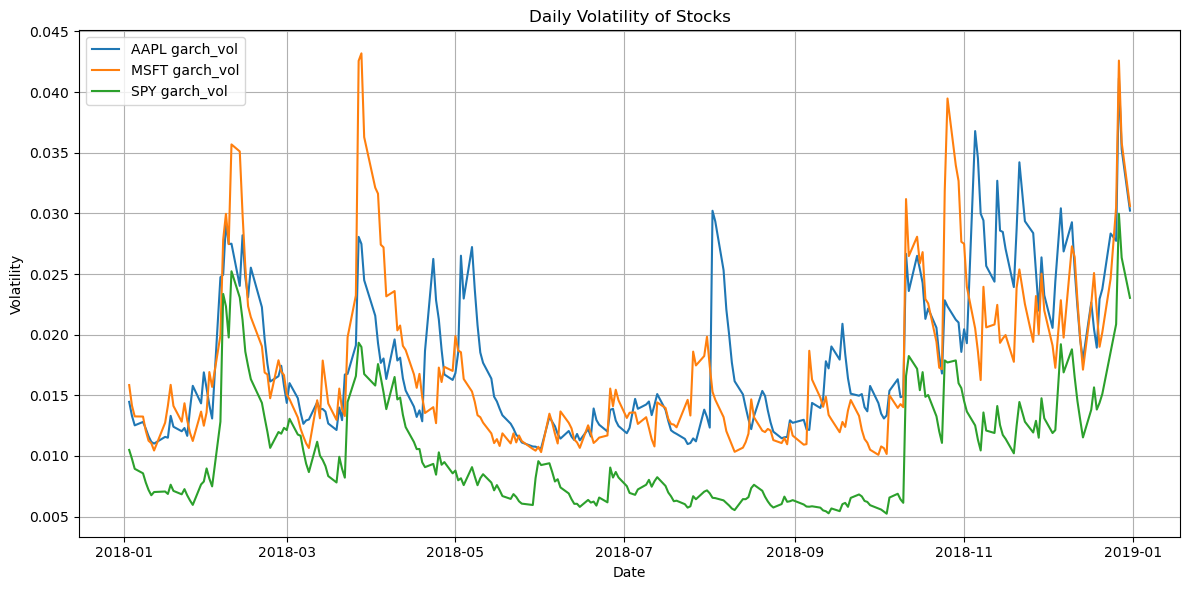

In [43]:
plot_daily_vol(daily_data)

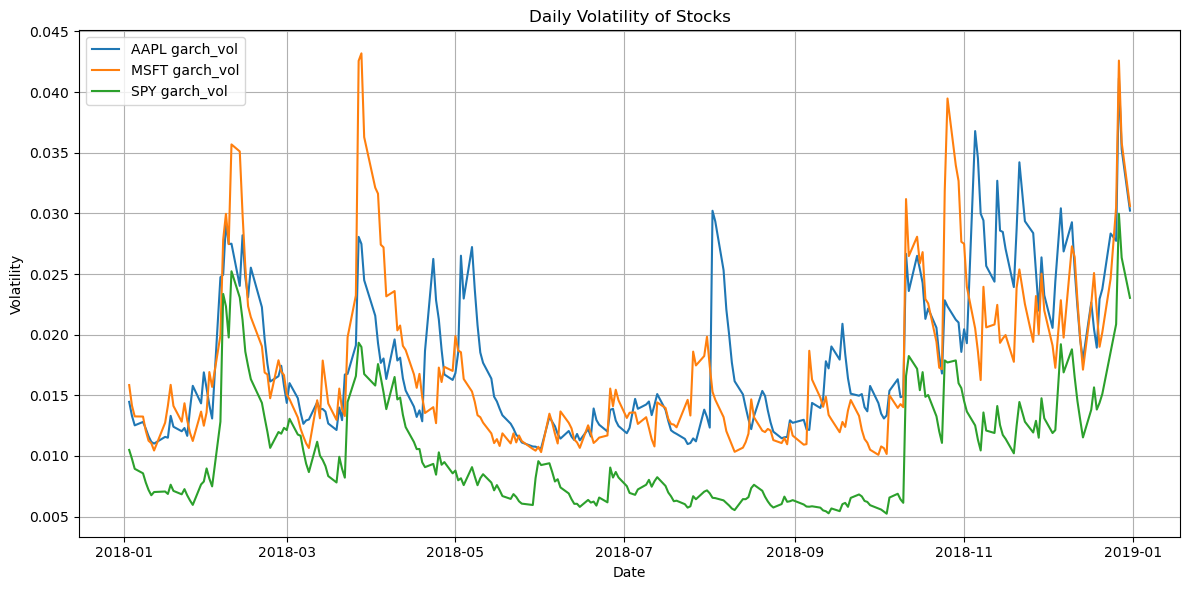

In [47]:
plot_daily_vol(daily_data)

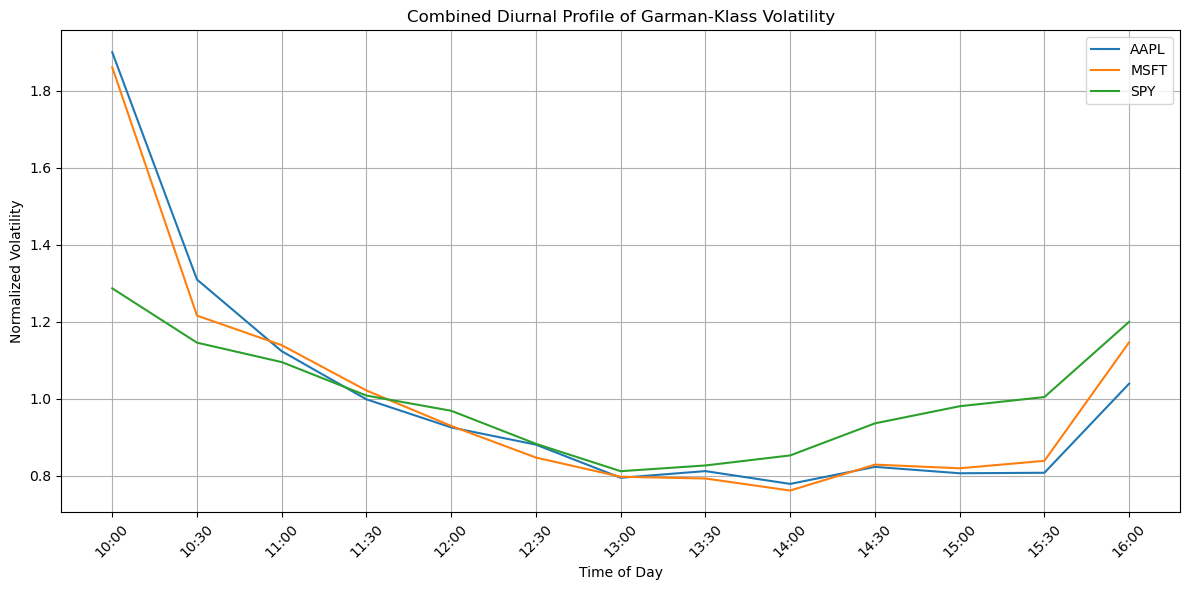

In [46]:
plot_diurnal_profile(diurnal_results)